Epoch 0, Loss: 63797.992188
Epoch 200, Loss: 0.594309
Epoch 400, Loss: 0.432195
Epoch 600, Loss: 0.303116
Epoch 800, Loss: 0.245455
Epoch 1000, Loss: 0.219925
Epoch 1200, Loss: 0.203536
Epoch 1400, Loss: 0.346085
Epoch 1600, Loss: 0.207779
Epoch 1800, Loss: 0.176015
Epoch 2000, Loss: 0.204893
Epoch 2200, Loss: 0.158819
Epoch 2400, Loss: 0.147491
Epoch 2600, Loss: 0.615795
Epoch 2800, Loss: 0.134254
Epoch 3000, Loss: 0.254494
Epoch 3200, Loss: 0.124376
Epoch 3400, Loss: 0.943614
Epoch 3600, Loss: 78.179214
Epoch 3800, Loss: 0.106154
Epoch 4000, Loss: 0.174094
Epoch 4200, Loss: 0.096738
Epoch 4400, Loss: 0.088989
Epoch 4600, Loss: 1.821502
Epoch 4800, Loss: 36.556065
Epoch 5000, Loss: 0.072195
Epoch 5200, Loss: 0.081776
Epoch 5400, Loss: 32.863716
Epoch 5600, Loss: 0.056496
Epoch 5800, Loss: 0.173479


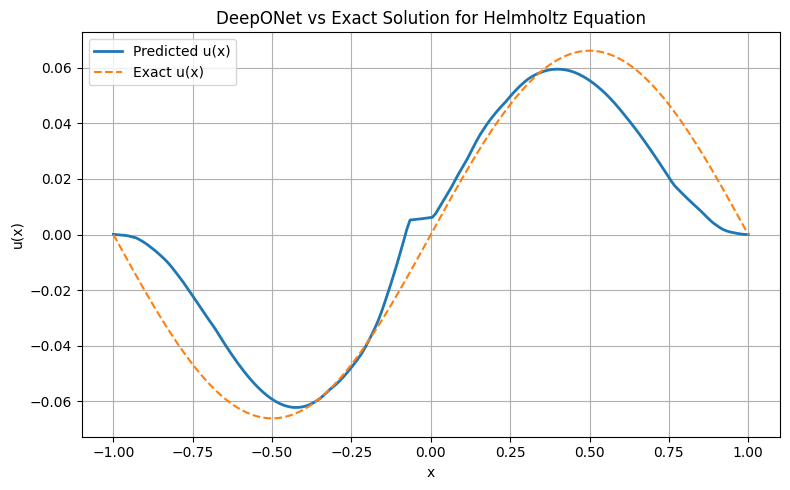

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------------
# 1. Chebyshev Nodes and Diff Matrix
# -----------------------------
def chebyshev_nodes(N):
    k = torch.arange(N + 1, dtype=torch.float32)
    x = torch.cos(torch.pi * k / N)
    return x.unsqueeze(1)

def chebyshev_diff_matrix(N):
    x = torch.cos(torch.pi * torch.arange(N + 1) / N)
    c = torch.ones(N + 1)
    c[0], c[-1] = 2, 2
    c = c * ((-1) ** torch.arange(N + 1))
    X = x.repeat(N + 1, 1)
    dX = X - X.T
    D = torch.outer(c, 1 / c) / (dX + torch.eye(N + 1))
    D = D - torch.diag(torch.sum(D, dim=1))
    for i in range(N + 1):
        if i == 0:
            D[i, i] = (2 * N ** 2 + 1) / 6
        elif i == N:
            D[i, i] = -(2 * N ** 2 + 1) / 6
        else:
            D[i, i] = -x[i] / (2 * (1 - x[i] ** 2))

    return x.unsqueeze(1), D

# -----------------------------
# 2. Forcing Function
# -----------------------------
def forcing_function(x):
    return torch.sin(torch.pi * x)

# -----------------------------
# 3. Exact Solution for Helmholtz Equation
# -----------------------------
def exact_solution(x, k):
    pi_tensor = torch.tensor(torch.pi)  # make pi a tensor
    k_tensor = torch.tensor(k, dtype=torch.float32)  # ensure k is a tensor

    denom = k_tensor**2 - pi_tensor**2
    rhs = torch.sin(pi_tensor) / denom

    # Compute sin and cos for k
    sin_k = torch.sin(k_tensor)
    cos_k = torch.cos(k_tensor)
    sin_neg_k = torch.sin(-k_tensor)
    cos_neg_k = torch.cos(-k_tensor)

    # Build system matrix and RHS
    M = torch.stack([
        torch.tensor([sin_neg_k.item(), cos_neg_k.item()]),
        torch.tensor([sin_k.item(), cos_k.item()])
    ])
    b = torch.tensor([-rhs.item(), -rhs.item()])

    # Solve for A and B
    AB = torch.linalg.solve(M, b)
    A, B = AB[0], AB[1]

    # Compute solution
    u_p = torch.sin(pi_tensor * x) / denom
    u_h = A * torch.sin(k_tensor * x) + B * torch.cos(k_tensor * x)
    return u_p + u_h

# -----------------------------
# 4. DeepONet Model
# -----------------------------
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=64):
        super(DeepONet, self).__init__()
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, f_input, x_input):
        branch_out = self.branch_net(f_input)
        trunk_out = self.trunk_net(x_input)
        combined = branch_out * trunk_out
        return self.output_layer(combined)

# -----------------------------
# 5. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 20
k_val = 5.0
lr = 1e-3
epochs = 6000

x_nodes, D = chebyshev_diff_matrix(N)
x_nodes = x_nodes.to(device)
D = D.to(device)
f_vals = forcing_function(x_nodes).to(device)

model = DeepONet(branch_input_dim=1, trunk_input_dim=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# -----------------------------
# 6. Training Loop
# -----------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    u_pred = model(f_vals, x_nodes)
    du = D @ u_pred
    d2u = D @ du
    residual = d2u + k_val**2 * u_pred - f_vals
    loss_pde = mse(residual, torch.zeros_like(residual))
    loss_bc = mse(u_pred[0], torch.tensor([0.0], device=device)) + mse(u_pred[-1], torch.tensor([0.0], device=device))
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# -----------------------------
# 7. Evaluation and Plot
# -----------------------------
model.eval()
with torch.no_grad():
    x_plot = torch.linspace(-1, 1, 200).unsqueeze(1).to(device)
    f_plot = forcing_function(x_plot)
    u_pred_plot = model(f_plot, x_plot).cpu()
    u_exact_plot = exact_solution(x_plot.cpu(), k_val)

plt.figure(figsize=(8, 5))
plt.plot(x_plot.cpu().numpy(), u_pred_plot.numpy(), label='Predicted u(x)', linewidth=2)
plt.plot(x_plot.cpu().numpy(), u_exact_plot.numpy(), label='Exact u(x)', linestyle='--')
plt.title('DeepONet vs Exact Solution for Helmholtz Equation')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:

import torch
import math


def get_clenshaw_curtis_weights_mat(n: int) -> torch.Tensor:
    """
    Returns a diagonal matrix of Clenshaw-Curtis weights for n intervals (n+1 nodes).
    Nodes are in descending order.
    """
    # Number of nodes
    N = n + 1
    # k = torch.arange(0, N, dtype=torch.float64)

    # Compute weights using the explicit formula with correction factor
    weights = torch.zeros(N, dtype=torch.float64)
    m = N // 2  # floor(N/2)
    for i in range(N):
        s = 0.0
        for j in range(1, m + 1):
            bj = 0.5 if j == m and N % 2 == 0 else 1.0  # correction factor for last term
            s += bj * (2 * math.cos(2 * j * i * math.pi / N)) / (4 * j**2 - 1)
        weights[i] = (2 / N) * (1 - s)

    # Reverse for descending Chebyshev nodes
    weights = torch.flip(weights, dims=[0])

    # Return diagonal matrix
    return torch.diag(weights)

# Test function: f(x) = cos(x)
def test_clenshaw_curtis(n):
    # Nodes in descending order
    nodes = torch.flip(torch.cos(torch.arange(0, n+1, dtype=torch.float64) * math.pi / n), dims=[0])
    f_values = torch.cos(nodes)
    
    # Get weights matrix
    W = get_clenshaw_curtis_weights_mat(n)
    
    # Approximate integral
    approx_integral = torch.matmul(W.diag(), f_values).sum().item()
    
    # Exact integral of cos(x) over [-1,1]
    exact_integral = math.sin(1) - math.sin(-1)  # = 2*sin(1)
    
    print(f"n = {n}")
    print(f"Approx integral: {approx_integral:.12f}")
    print(f"Exact integral:  {exact_integral:.12f}")
    print(f"Error:           {abs(approx_integral - exact_integral):.2e}")
    print("-" * 50)

# Run tests for a few n values
for n in [4, 8, 16, 32, 64, 128]:
    test_clenshaw_curtis(n)


n = 4
Approx integral: 1.567226253448
Exact integral:  1.682941969616
Error:           1.16e-01
--------------------------------------------------
n = 8
Approx integral: 1.626137465148
Exact integral:  1.682941969616
Error:           5.68e-02
--------------------------------------------------
n = 16
Approx integral: 1.655619691343
Exact integral:  1.682941969616
Error:           2.73e-02
--------------------------------------------------
n = 32
Approx integral: 1.669692585342
Exact integral:  1.682941969616
Error:           1.32e-02
--------------------------------------------------
n = 64
Approx integral: 1.676441146849
Exact integral:  1.682941969616
Error:           6.50e-03
--------------------------------------------------
n = 128
Approx integral: 1.679725371185
Exact integral:  1.682941969616
Error:           3.22e-03
--------------------------------------------------


In [12]:
dtype = torch.float32
def cheb_sensors(m):
    j = torch.arange(m, dtype=dtype, device=device)
    xi = torch.cos(j*math.pi/(m-1))
    return xi.to(torch.float32)


cheb_sensors(5)

tensor([ 1.0000e+00,  7.0711e-01, -4.3711e-08, -7.0711e-01, -1.0000e+00])

In [54]:
cheb_sensors(4)

tensor([ 1.0000,  0.5000, -0.5000, -1.0000])

Epoch 0, Loss: 933.752136
Epoch 200, Loss: 0.850598
Epoch 400, Loss: 0.378225
Epoch 600, Loss: 0.199393
Epoch 800, Loss: 0.103202
Epoch 1000, Loss: 0.060529
Epoch 1200, Loss: 0.044336
Epoch 1400, Loss: 0.041187
Epoch 1600, Loss: 0.036113
Epoch 1800, Loss: 0.035225
Epoch 2000, Loss: 1.618642
Epoch 2200, Loss: 0.030465
Epoch 2400, Loss: 0.028942
Epoch 2600, Loss: 0.027590
Epoch 2800, Loss: 0.069000
Epoch 3000, Loss: 0.023953
Epoch 3200, Loss: 0.023513
Epoch 3400, Loss: 0.021139
Epoch 3600, Loss: 0.020201
Epoch 3800, Loss: 0.018059
Epoch 4000, Loss: 0.016966
Epoch 4200, Loss: 0.016385
Epoch 4400, Loss: 0.014529
Epoch 4600, Loss: 0.012662
Epoch 4800, Loss: 0.024455
Epoch 5000, Loss: 0.010773
Epoch 5200, Loss: 0.010110
Epoch 5400, Loss: 0.008298
Epoch 5600, Loss: 0.008154
Epoch 5800, Loss: 0.006729


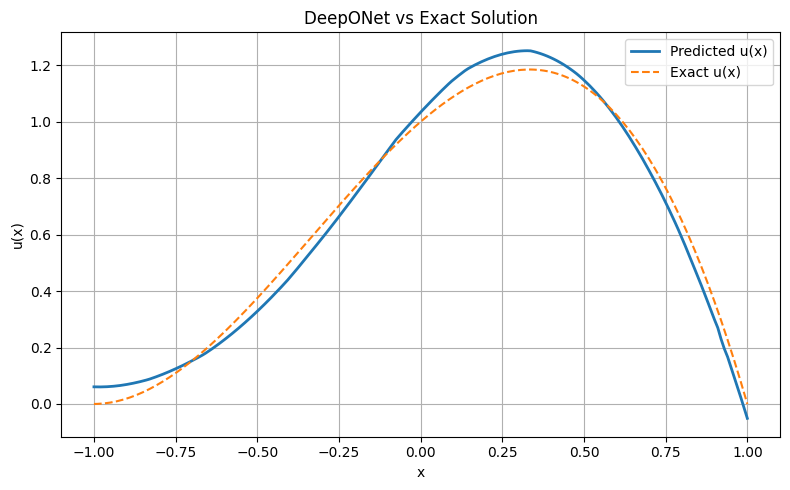

In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------------
# 1. Chebyshev Nodes and Diff Matrix
# -----------------------------
def chebyshev_nodes(N):
    k = torch.arange(N + 1, dtype=torch.float32)
    x = torch.cos(torch.pi * k / N)
    return x.unsqueeze(1)

def chebyshev_diff_matrix(N):
    x = torch.cos(torch.pi * torch.arange(N + 1) / N)
    c = torch.ones(N + 1)
    c[0], c[-1] = 2, 2
    c = c * ((-1) ** torch.arange(N + 1))
    X = x.repeat(N + 1, 1)
    # dX = X - X.T
    dX = X.T - X
    D = torch.outer(c, 1 / c) / (dX + torch.eye(N + 1))
    D = D - torch.diag(torch.sum(D, dim=1))
    for i in range(N + 1):
        if i == 0:
            D[i, i] = (2 * N ** 2 + 1) / 6
        elif i == N:
            D[i, i] = -(2 * N ** 2 + 1) / 6
        else:
            D[i, i] = -x[i] / (2 * (1 - x[i] ** 2))
    return x.unsqueeze(1), D

# -----------------------------
# 2. Forcing Function
# -----------------------------
def forcing_function(x):
    return -25*x**3 - 25*x**2 + 19*x + 23

# -----------------------------
# 3. Exact Solution
# -----------------------------
def exact_solution(x, k):
    return -x**3 - x**2 + x + 1

# -----------------------------
# 4. DeepONet Model
# -----------------------------
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=64):
        super(DeepONet, self).__init__()
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, f_input, x_input):
        branch_out = self.branch_net(f_input)
        trunk_out = self.trunk_net(x_input)
        combined = branch_out * trunk_out
        return self.output_layer(combined)

# -----------------------------
# 5. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 20
k_val = 5.0
lr = 1e-3
epochs = 6000

x_nodes, D = chebyshev_diff_matrix(N)
x_nodes = x_nodes.to(device)
D = D.to(device)
f_vals = forcing_function(x_nodes).to(device)

model = DeepONet(branch_input_dim=1, trunk_input_dim=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# -----------------------------
# 6. Training Loop
# -----------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    u_pred = model(f_vals, x_nodes)
    du = D @ u_pred
    d2u = D @ du
    residual = d2u + k_val**2 * u_pred - f_vals
    loss_pde = mse(residual, torch.zeros_like(residual))
    loss_bc = mse(u_pred[0], torch.tensor([0.0], device=device)) + mse(u_pred[-1], torch.tensor([0.0], device=device))
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# -----------------------------
# 7. Evaluation and Plot
# -----------------------------
model.eval()
with torch.no_grad():
    x_plot = torch.linspace(-1, 1, 200).unsqueeze(1).to(device)
    f_plot = forcing_function(x_plot)
    u_pred_plot = model(f_plot, x_plot).cpu()
    u_exact_plot = exact_solution(x_plot.cpu(), k_val)

plt.figure(figsize=(8, 5))
plt.plot(x_plot.cpu().numpy(), u_pred_plot.numpy(), label='Predicted u(x)', linewidth=2)
plt.plot(x_plot.cpu().numpy(), u_exact_plot.numpy(), label='Exact u(x)', linestyle='--')
plt.title('DeepONet vs Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
dtype = torch.float32

def cheb_sensors(m, device='cpu', dtype=dtype, a=-1.0, b=1.0):
    """
    Generate m Chebyshev nodes in descending order (from 1 to -1).
    For m nodes including endpoints: x_i = cos(i*π/(m-1)) for i=0,...,m-1
    """
    if m < 2:
        raise ValueError(f"m must be >= 2, got {m}")
    j = torch.arange(m, dtype=dtype, device=device)
    xi = torch.cos(j * math.pi / (m - 1))  # nodes in [-1, 1], descending order
    
    # Scale from [-1, 1] to [a, b]
    scaled_xi = 0.5 * (b - a) * xi + 0.5 * (b + a)
    return scaled_xi
    
def chebyshev_diff_matrix(N, device='cpu', dtype=dtype):
    x = cheb_sensors(N)
    c = torch.ones(N, device=device, dtype=dtype)
    c[0], c[-1] = 2, 2
    c = c * ((-1) ** torch.arange(N, device=device, dtype=dtype))
    X = x.repeat(N, 1)
    # dX = X - X.T
    dX = X.T - X
    D = torch.outer(c, 1 / c) / (dX + torch.eye(N, device=device, dtype=dtype))
    # D = (c.unsqueeze(1) / c.unsqueeze(0)) / (dX + torch.eye(N, device=device, dtype=dtype))
    D = D - torch.diag(torch.sum(D, dim=1))

    for i in range(1, N - 1):
        D[i, i] = -x[i] / (2 * (1 - x[i] ** 2))

    N_ex = (N - 1)
    endpoint_val = (2.0 * N_ex * N_ex + 1.0) / 6.0
    D[0, 0] = endpoint_val
    D[-1, -1] = -endpoint_val
    
    return x, D

    
def test_first_derivative():
    N = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x, D = chebyshev_diff_matrix(N)
    # Test function: u(x) = x^3
    u = x**3
    # Analytical derivative: u'(x) = 3x^2
    u_prime_exact = 3 * x**2
    
    # Numerical derivative using D
    u_prime_num = torch.matmul(D, u)
    
    # Compute error
    error = torch.norm(u_prime_num - u_prime_exact)
    
    # print("Chebyshev nodes:", x)
    print(f"Error norm: {error.item():.6e}")
    # print("Numerical derivative:", u_prime_num)
    # print("Exact derivative:", u_prime_exact)


def test_second_derivative():
    N = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x, D = chebyshev_diff_matrix(N)
    
    # Test function: u(x) = x^3
    u = x**3
    u_prime_exact = 6 * x
    
    # Numerical derivative using D
    D2 = torch.matmul(D, D)
    u_prime_num = torch.matmul(D2, u)

    # Compute error
    error = torch.norm(u_prime_num - u_prime_exact)
    
    # print("Chebyshev nodes:", x)
    print(f"Error norm: {error.item():.6e}")
    # print("Numerical derivative:", u_prime_num)
    # print("Exact derivative:", u_prime_exact)


test_first_derivative()
test_second_derivative()


Error norm: 2.496987e-01
Error norm: 9.719996e+02


In [14]:
x, D = chebyshev_diff_matrix(6)
D

tensor([[  8.5000, -10.4721,   2.8944,  -1.5279,   1.1056,  -0.5000],
        [  2.6180,  -1.1708,  -2.0000,   0.8944,  -0.6180,   0.2764],
        [ -0.7236,   2.0000,  -0.1708,  -1.6180,   0.8944,  -0.3820],
        [  0.3820,  -0.8944,   1.6180,   0.1708,  -2.0000,   0.7236],
        [ -0.2764,   0.6180,  -0.8944,   2.0000,   1.1708,  -2.6180],
        [  0.5000,  -1.1056,   1.5279,  -2.8944,  10.4721,  -8.5000]])